# Import Libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import joblib
import json
import pandas as pd
import copy
import hashlib

import src.util as util

# 1. Load Config File

In [2]:
params = util.load_config()

# 2. Load Dataset

In [3]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    x_train = util.pickle_load(params["train_feng_set_path"][0])
    y_train = util.pickle_load(params["train_feng_set_path"][1])

    return x_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    # Load valid set
    x_valid = util.pickle_load(params["valid_feng_set_path"][0])
    y_valid = util.pickle_load(params["valid_feng_set_path"][1])

    return x_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    # Load test set
    x_test = util.pickle_load(params["test_feng_set_path"][0])
    y_test = util.pickle_load(params["test_feng_set_path"][1])

    return x_test, y_test

In [4]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    util.print_debug("Loading dataset.")

    # Load train set
    x_train, y_train = load_train_feng(params)

    # Load valid set
    x_valid, y_valid = load_valid_feng(params)

    # Load test set
    x_test, y_test = load_test_feng(params)

    # Debug message
    util.print_debug("Dataset loaded.")

    # Return the dataset
    return x_train, y_train, x_valid, y_valid, x_test, y_test

# 3. Create Training Log Template

In [5]:
def training_log_template() -> dict:
    # Debug message
    util.print_debug("Creating training log template.")
    
    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [6]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

# 4. Training & Evaluation

### Create Model Object

In [7]:
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    lgr = LogisticRegression()
    dct = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    xgb = XGBClassifier()

    # Create list of model
    list_of_model = [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},\
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""}
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

### Training Baseline Model

In [8]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    x_train, y_train, \
    x_valid, y_valid, \
    x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["macro avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

In [9]:
list_of_trained_model, training_log = train_eval("Baseline", params)

2023-07-09 00:25:49.600887 Loading dataset.
2023-07-09 00:25:49.642526 Dataset loaded.
2023-07-09 00:25:49.642575 Creating training log template.
2023-07-09 00:25:49.642589 Training log template created.
2023-07-09 00:25:49.642603 Training model based on configuration data: SMOTE
2023-07-09 00:25:49.642614 Creating model objects.
2023-07-09 00:25:49.642762 Model objects created.
2023-07-09 00:25:49.642850 Training model: LogisticRegression
2023-07-09 00:25:49.721564 Evalutaing model: LogisticRegression
2023-07-09 00:25:49.730629 Logging: LogisticRegression
2023-07-09 00:25:49.730886 Model LogisticRegression has been trained for configuration data SMOTE.
2023-07-09 00:25:49.730905 Training model: DecisionTreeClassifier
2023-07-09 00:25:49.738163 Evalutaing model: DecisionTreeClassifier
2023-07-09 00:25:49.745230 Logging: DecisionTreeClassifier
2023-07-09 00:25:49.746087 Model DecisionTreeClassifier has been trained for configuration data SMOTE.
2023-07-09 00:25:49.746112 Training model:

/root/miniconda3/envs/mlprocess_asistensi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-07-09 00:25:49.935859 Evalutaing model: RandomForestClassifier
2023-07-09 00:25:49.953724 Logging: RandomForestClassifier
2023-07-09 00:25:50.022373 Model RandomForestClassifier has been trained for configuration data SMOTE.
2023-07-09 00:25:50.022409 Training model: XGBClassifier
2023-07-09 00:25:50.143207 Evalutaing model: XGBClassifier
2023-07-09 00:25:50.181776 Logging: XGBClassifier
2023-07-09 00:25:50.186399 Model XGBClassifier has been trained for configuration data SMOTE.
2023-07-09 00:25:50.237087 All combination models and configuration data has been trained.


### Choose Best Performance Baseline Model

In [10]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid = load_valid_feng(params)
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid)

            # Re-asses prediction result
            eval_res = classification_report(y_valid, y_pred, output_dict = True)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["macro avg"]["f1-score"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log

In [11]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-07-09 00:25:50.319589 Choosing model by metrics score.
2023-07-09 00:25:50.319944 Converting training log type of data from dict to dataframe.
2023-07-09 00:25:50.324205 Trying to load previous production model.
2023-07-09 00:25:50.324322 No previous production model detected, choosing best model only from current trained model.
2023-07-09 00:25:50.324340 Sorting training log by f1 macro avg and training time.
2023-07-09 00:25:50.330535 Searching model data based on sorted training log.
2023-07-09 00:25:50.342103 Model chosen.


In [12]:
model

{'model_data': {'model_name': 'RandomForestClassifier',
  'model_object': RandomForestClassifier(),
  'model_uid': 'f8a331fec939b1845995e99f7ad4a15f'},
 'model_log': {'model_name': 'Production-RandomForestClassifier',
  'model_uid': 'f8a331fec939b1845995e99f7ad4a15f',
  'training_time': 0.189726,
  'training_date': '2023-07-09 00:25:49.953766',
  'performance': {'0': {'precision': 0.8,
    'recall': 0.5517241379310345,
    'f1-score': 0.6530612244897959,
    'support': 29},
   '1': {'precision': 0.8194444444444444,
    'recall': 0.9365079365079365,
    'f1-score': 0.874074074074074,
    'support': 63},
   'accuracy': 0.8152173913043478,
   'macro avg': {'precision': 0.8097222222222222,
    'recall': 0.7441160372194855,
    'f1-score': 0.763567649281935,
    'support': 92},
   'weighted avg': {'precision': 0.8133152173913044,
    'recall': 0.8152173913043478,
    'f1-score': 0.8044069801833776,
    'support': 92}},
  'f1_score_avg': 0.763567649281935,
  'data_configurations': 'SMOTE'}}

### Hyperparameter Tuning

In [13]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres
    dist_params_xgb = {
        "n_estimators" : [50, 100, 200, 300, 400, 500]
    }
    dist_params_dct = {
        "algorithm" : ["gini", "entropy", "log_loss"],
        "min_sample_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_sample_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }
    dist_params_lgr = {
        "penalty" : ["l1", "l2", "elasticnet", "none"],
        "C" : [0.01, 0.05, 0.10, 0.15, 0.20, 0.30, 0.60, 0.90, 1],
        "solver" : ["saga"],
        "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    }
    dist_params_rfc = {
        "algorithm" : ["gini", "entropy", "log_loss"],
        "n_estimators" : [50, 100, 200, 300, 400, 500],
        "min_sample_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_sample_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "DecisionTreeClassifier": dist_params_dct,
        "LogisticRegression": dist_params_lgr,
        "RandomForestClassifier": dist_params_rfc
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [14]:
def hyper_params_tuning(model: dict) -> list:
    # Create copy of current best baseline model
    model = copy.deepcopy(model)

    # Create model's parameter distribution
    dist_params = create_dist_params(model["model_data"]["model_name"])

    # Create model object
    model_rsc = GridSearchCV(model["model_data"]["model_object"], dist_params, n_jobs = -1)
    model_data = {
        "model_name": model["model_data"]["model_name"],
        "model_object": model_rsc,
        "model_uid": ""
    }
    
    # Return model object
    return [model_data]

In [15]:
model

{'model_data': {'model_name': 'RandomForestClassifier',
  'model_object': RandomForestClassifier(),
  'model_uid': 'f8a331fec939b1845995e99f7ad4a15f'},
 'model_log': {'model_name': 'Production-RandomForestClassifier',
  'model_uid': 'f8a331fec939b1845995e99f7ad4a15f',
  'training_time': 0.189726,
  'training_date': '2023-07-09 00:25:49.953766',
  'performance': {'0': {'precision': 0.8,
    'recall': 0.5517241379310345,
    'f1-score': 0.6530612244897959,
    'support': 29},
   '1': {'precision': 0.8194444444444444,
    'recall': 0.9365079365079365,
    'f1-score': 0.874074074074074,
    'support': 63},
   'accuracy': 0.8152173913043478,
   'macro avg': {'precision': 0.8097222222222222,
    'recall': 0.7441160372194855,
    'f1-score': 0.763567649281935,
    'support': 92},
   'weighted avg': {'precision': 0.8133152173913044,
    'recall': 0.8152173913043478,
    'f1-score': 0.8044069801833776,
    'support': 92}},
  'f1_score_avg': 0.763567649281935,
  'data_configurations': 'SMOTE'}}

In [16]:
list_of_trained_model, training_log = train_eval("Hyperparams_Tuning", params, hyper_params_tuning(model))

2023-07-09 00:28:02.006063 Loading dataset.
2023-07-09 00:28:02.148806 Dataset loaded.
2023-07-09 00:28:02.149202 Creating training log template.
2023-07-09 00:28:02.149633 Training log template created.
2023-07-09 00:28:02.149694 Training model based on configuration data: SMOTE
2023-07-09 00:28:02.180812 Training model: RandomForestClassifier


ValueError: Invalid parameter 'algorithm' for estimator RandomForestClassifier(). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [17]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-07-09 00:28:40.642592 Choosing model by metrics score.
2023-07-09 00:28:40.642716 Converting training log type of data from dict to dataframe.
2023-07-09 00:28:40.688126 Trying to load previous production model.
2023-07-09 00:28:40.760638 Previous production model loaded.
2023-07-09 00:28:40.760681 Loading validation data.
2023-07-09 00:28:40.763323 Checking compatibilty previous production model's input with current train data's features.
2023-07-09 00:28:40.763702 Features compatible.
2023-07-09 00:28:40.763724 Reassesing previous model performance using current validation data.
2023-07-09 00:28:40.800026 Assessing complete.
2023-07-09 00:28:40.800057 Storing new metrics data to previous model structure.
2023-07-09 00:28:40.800065 Adding previous model data to current training log and list of model
2023-07-09 00:28:40.823512 Sorting training log by f1 macro avg and training time.
2023-07-09 00:28:40.834305 Searching model data based on sorted training log.
2023-07-09 00:28:40.86

In [18]:
x_valid, y_valid = load_valid_feng(params)

In [19]:
y_pred = model["model_data"]["model_object"].predict(x_valid)

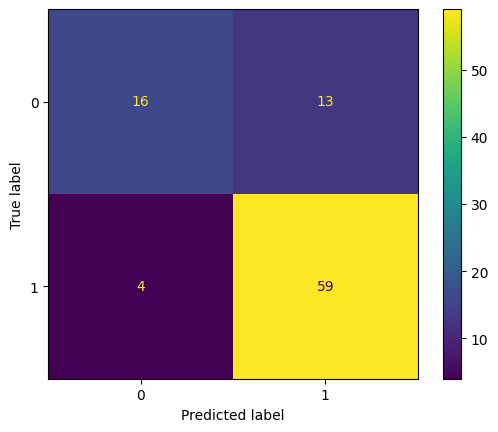

In [20]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_valid,
                            y_pred = y_pred,
                           labels = [1,0]))

              precision    recall  f1-score   support

           1       0.82      0.94      0.87        63
           0       0.80      0.55      0.65        29

    accuracy                           0.82        92
   macro avg       0.81      0.74      0.76        92
weighted avg       0.81      0.82      0.80        92



In [22]:
x_test, y_test = load_test_feng(params)

In [23]:
y_pred_test = model["model_data"]["model_object"].predict(x_test)

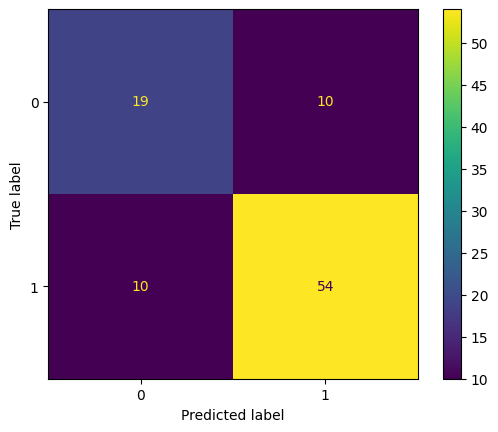

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                           labels = [1,0]))

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        64
           0       0.66      0.66      0.66        29

    accuracy                           0.78        93
   macro avg       0.75      0.75      0.75        93
weighted avg       0.78      0.78      0.78        93

